In [0]:
import os; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Unsupervised Learning')

In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from util import error_rate, getKaggleMNIST

In [0]:
class AutoEncoder(object):
    def __init__(self, D, M, an_id):
        self.M = M
        self.id = an_id
        self.build(D, M)

    def set_session(self, session):
        self.session = session

    def build(self, D, M):
        #self.W = tf.Variable(tf.random_normal(shape=(D,M)))
        self.W = tf.Variable(tf.random_normal(shape=(D, M)))
        self.bh = tf.Variable(np.zeros(M).astype(np.float32))
        self.bo = tf.Variable(np.zeros(D).astype(np.float32))

        self.X_in = tf.placeholder(tf.float32, shape= (None,D))
        self.Z = self.forward_hidden(self.X_in) #for transform later
        self.X_hat = self.forward_output(self.X_in)

        #using the naive formulation for cross-entropy
        #will have numerical stability issues if X_hat = 0 or 1
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
            labels = self.X_in,
            logits = logits,    
            )
        )   
        #self.train_op = tf.train.MomentumOptimizer(1e-3, momentum=0.9).minimize(self.cost)
        self.train_op = tf.train.AdamOptimizer(1e-1).minimize(self.cost)

    #Train
    def fit(self, X, epochs=1, batch_sz=100, show_fig=False):
        N,D = X.shape
        n_batches = N // batch_sz

        costs= []
        print("Training encoder: %s" %self.id)
        for i in range(epochs):
            print("Epochs", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                _,c = self.session.run((self.train_op, self.cost), feed_dict={self.X_in:batch})
                if j%10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", c)
                costs.append(c)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def transform(self, X):
        #accepts and returns a real numpy array
        #unlike forward_hidden and forward_output
        #which deal with tensorflow variables
        return self.session.run(self.Z, feed_dict={self.X_in: X})

    def predict(self, X):
        #accepts and returns a real numpy array
        #unlike forward_hidden and forward_output
        #which deal with tensorflow variables
        return self.session.run(self.X_hat, feed_dict={self.X_in: X})

    def forward_hidden(self, X):
        Z = tf.nn.sigmoid(tf.matmul(X, self.W) +self.bh)
        return Z

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.matmul(Z, tf.transpose(self.W)) + self.bo

    def forward_output(self, X):
        return tf.nn.sigmoid(self.forward_logits(X))

class DNN(object):
    def __init__(self, D, hidden_layer_sizes, K, UnsupervisedModel = AutoEncoder):
        self.hidden_layers = []
        count = 0
        input_size = D        
        for output_size in hidden_layer_sizes:
            ae = UnsupervisedModel(input_size, output_size, count)
            self.hidden_layers.append(ae)
            count += 1
            input_size = output_size
        self.build_final_layer(D, hidden_layer_sizes[-1], K)

    def set_session(self, session):
        self.session = session
        for layer in self.hidden_layers:
            layer.set_session(session)

    def build_final_layer(self, D, M, K):
        #initialize logistic regress
        self.W = tf.Variable(tf.random_normal(shape=(M, K)))
        self.b = tf.Variable(np.zeros(K).astype(np.float32))

        self.X = tf.placeholder(tf.float32, shape=(None, D))
        labels = tf.placeholder(tf.int32, shape=(None,))
        self.Y = labels
        logits = self.forward(self.X)

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = logits,
                labels = labels
            )
        )
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost)
        self.prediction = tf.argmax(logits, 1)

    def fit(self, X, Y, Xtest, Ytest, pretrain=True, epochs=1, batch_sz=100):
        N = len(X)

        #greedy layer-wise training of autoencoders
        pretrain_epochs = 1
        if not pretrain:
            pretrain_epochs = 0

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)
            #create current input for the next layer
            current_input = ae.transform(current_input)
        
        n_batches = N // batch_sz
        costs = []
        print('Supervised Training..')
        for i in range(epochs):
            print("Epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                self.session.run(self.train_op, feed_dict={self.X: Xbatch, self.Y: Ybatch})
                c, p = self.session.run((self.cost, self.prediction), feed_dict={self.X: Xtest, self.Y: Ytest})
                error = error_rate(p, Ytest)
                if j%10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "Cost:", c, "error:", error)
                costs.append(c)
        plt.plot(costs)
        plt.show()

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        #logistic layer
        logits = tf.matmul(current_input, self.W) + self.b
        return logits

def test_pretraining_dnn():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
    #dnn = DNN([1000, 750, 500])
    #dnn.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=3)
    #vs
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)
    _, D = Xtrain.shape
    K = len(set(Ytrain))
    dnn = DNN(D, [1000, 750, 500], K)
    init_op = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init_op)
        dnn.set_session(session)
        dnn.fit(Xtrain, Ytrain, Xtest, Ytest, pretrain=True, epochs=10)

def test_single_autoencoder():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)
    _, D = Xtrain.shape
    autoencoder = AutoEncoder(D, 300, 0)
    init_op = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init_op)
        autoencoder.set_session(session)
        autoencoder.fit(Xtrain, show_fig=True)
        
        done = False
        while not done:
            i = np.random.choice(len(Xtest))
            x = Xtest[i]
            y = autoencoder.predict([x])
            
            plt.subplot(1,2,1)
            plt.imshow(x.reshape(28,28), cmap='gray')
            plt.title('Original')

            plt.subplot(1,2,2)
            plt.imshow(y.reshape(28,28), cmap='gray')
            plt.title('Reconstructed')

            plt.show()

            ans = input('Generate another?')
            if ans and ans[0] in ('n' or 'Y'):
                done = True
                 

Training encoder: 0
Epochs 0
j / n_batches: 0 / 590 cost: 4.4310594
j / n_batches: 10 / 590 cost: 0.29453224
j / n_batches: 20 / 590 cost: 0.24996263
j / n_batches: 30 / 590 cost: 0.21770371
j / n_batches: 40 / 590 cost: 0.19242199
j / n_batches: 50 / 590 cost: 0.19584356
j / n_batches: 60 / 590 cost: 0.17223541
j / n_batches: 70 / 590 cost: 0.18568397
j / n_batches: 80 / 590 cost: 0.17021425
j / n_batches: 90 / 590 cost: 0.15780245
j / n_batches: 100 / 590 cost: 0.16025326
j / n_batches: 110 / 590 cost: 0.15846029
j / n_batches: 120 / 590 cost: 0.1410261
j / n_batches: 130 / 590 cost: 0.15318085
j / n_batches: 140 / 590 cost: 0.14069328
j / n_batches: 150 / 590 cost: 0.15116423
j / n_batches: 160 / 590 cost: 0.14461857
j / n_batches: 170 / 590 cost: 0.1461885
j / n_batches: 180 / 590 cost: 0.15462913
j / n_batches: 190 / 590 cost: 0.14770363
j / n_batches: 200 / 590 cost: 0.14124407
j / n_batches: 210 / 590 cost: 0.1442257
j / n_batches: 220 / 590 cost: 0.13981977
j / n_batches: 230 /

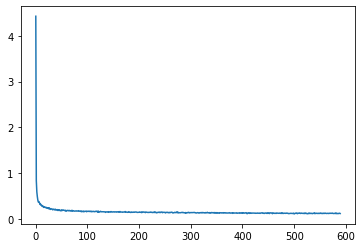

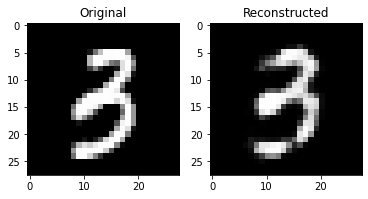

Generate another?y


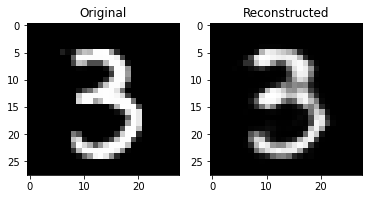

Generate another?y


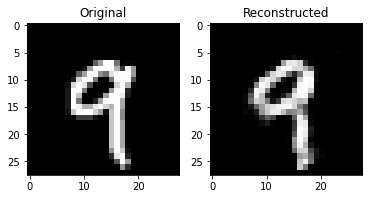

Generate another?y


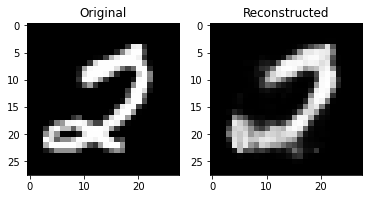

Generate another?n


In [13]:
if __name__ == '__main__':
    #test_pretraining_dnn()
    test_single_autoencoder()    